<a href="https://colab.research.google.com/github/kra268/Tutorials/blob/master/GCN_test_padding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
!nvidia-smi

Sat Apr 29 23:20:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [108]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

In [110]:
# Define a custom dataset class for the graph data
class GraphDataset(Dataset):
    def __init__(self, graph_list):
        self.graph_list = graph_list
    
    def __len__(self):
        return len(self.graph_list)
    
    def __getitem__(self, index):
        return self.graph_list[index]

In [111]:
# Define a function to pad the adjacency matrix
def pad_adj_matrix(adj_matrix, max_nodes):
    padded_adj_matrix = np.zeros((max_nodes, max_nodes))
    padded_adj_matrix[:adj_matrix.shape[0], :adj_matrix.shape[1]] = adj_matrix
    return padded_adj_matrix

In [112]:
# Define a function to create the adjacency matrix
def create_adj_matrix(edge_list, num_nodes):
    adj_matrix = np.zeros((num_nodes, num_nodes))
    for edge in edge_list:
        adj_matrix[edge[0], edge[1]] = 1
        adj_matrix[edge[1], edge[0]] = 1
    return adj_matrix

In [113]:
# Define the graph dataset
graph_list = [
    {
        'num_nodes': 5,
        'edge_list': [(0, 1), (1, 2), (2, 3), (3, 4)]
    },
    {
        'num_nodes': 4,
        'edge_list': [(0, 1), (1, 2), (2, 3)]
    },
    {
        'num_nodes': 6,
        'edge_list': [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5)]
    }
]

In [114]:
# Create the adjacency matrix with padding
max_nodes = max([graph['num_nodes'] for graph in graph_list])
adj_matrix_list = [pad_adj_matrix(create_adj_matrix(graph['edge_list'], graph['num_nodes']), max_nodes) for graph in graph_list]

In [115]:
# Convert the adjacency matrices to PyTorch tensors
adj_matrix_tensor_list = [torch.Tensor(adj_matrix) for adj_matrix in adj_matrix_list]

In [116]:
# Define the DataLoader
graph_dataset = GraphDataset(adj_matrix_tensor_list)
graph_dataloader = DataLoader(graph_dataset, batch_size=2, shuffle=True)

In [117]:
# Define the neural network
class GraphNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GraphNet, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [118]:
# Test the DataLoader
for batch_idx, batch in enumerate(graph_dataloader):
    print(batch.shape) # (batch_size, max_nodes, max_nodes)

torch.Size([2, 6, 6])
torch.Size([1, 6, 6])


In [119]:
adj_matrix_list

[array([[0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 array([[0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]]),
 array([[0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 1., 0.]])]

In [120]:
import torch.optim as optim

In [121]:
# Define the hyperparameters
input_size = max_nodes * max_nodes
hidden_size = 64
output_size = 1
lr = 0.01
num_epochs = 100

In [122]:
# Create the model and optimizer
model = GraphNet(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [123]:
# Train the model
for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(graph_dataloader):
        # Forward pass
        X = batch.view(-1, input_size)
        y = torch.rand((batch.shape[0], 1))
        y_pred = model(X)
        loss = torch.nn.functional.mse_loss(y_pred, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss={loss.item()}")

print("Training finished!")


Epoch 0: loss=0.014125511981546879
Epoch 10: loss=0.12451121211051941
Epoch 20: loss=0.2345961034297943
Epoch 30: loss=0.12322075664997101
Epoch 40: loss=0.0776350200176239
Epoch 50: loss=0.20254795253276825
Epoch 60: loss=0.008337586186826229
Epoch 70: loss=0.023341089487075806
Epoch 80: loss=0.026309411972761154
Epoch 90: loss=0.2413002997636795
Training finished!


In [124]:
import random
import networkx as nx

num_graphs = 100
min_nodes = 5
max_nodes = 20

graph_list = []

for i in range(num_graphs):
    num_nodes = random.randint(min_nodes, max_nodes)
    G = nx.dense_gnm_random_graph(num_nodes, num_nodes*(num_nodes-1)//4)
    graph_list.append(G)

print(f"Generated {num_graphs} graph data with varying number of nodes.")


Generated 100 graph data with varying number of nodes.


In [125]:
len(graph_list)

100

In [126]:
max_nodes = max([graph.number_of_nodes() for graph in graph_list])
max_nodes

20

In [127]:
adj_matrix_list = [pad_adj_matrix(create_adj_matrix(graph.edges(), graph.number_of_nodes()), max_nodes) for graph in graph_list]
len(adj_matrix_list)

100

In [128]:
# Convert to Tensor
adj_matrix_tensor_list = [torch.Tensor(adj_matrix) for adj_matrix in adj_matrix_list]

# Define the DataLoader
graph_dataset = GraphDataset(adj_matrix_tensor_list)


In [129]:
# Define the hyperparameters
input_size = max_nodes * max_nodes
hidden_size = 64
output_size = 1
lr = 0.01
num_epochs = 100

In [130]:
# Generating random target values
# It is important to note that the predictions
# will be terrible since, there is no real
# relationship between the target and the features.
import random

target_list = []

for i in range(num_graphs):
    target = random.uniform(0, 1)
    target_list.append(target)

target_list = torch.Tensor(target_list)
print(f"Generated {num_graphs} arbitrary target values.")


Generated 100 arbitrary target values.


In [131]:
# Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(graph_dataset, target_list, test_size=0.2, random_state=42)
len(X_test)

20

In [132]:
# This loader is important for training and testing 
graph_dataloader = DataLoader(X_train, batch_size=10, shuffle=True)
# Test the DataLoader
for batch_idx, batch in enumerate(graph_dataloader):
    print(batch.shape) # (batch_size, max_nodes, max_nodes)

torch.Size([10, 20, 20])
torch.Size([10, 20, 20])
torch.Size([10, 20, 20])
torch.Size([10, 20, 20])
torch.Size([10, 20, 20])
torch.Size([10, 20, 20])
torch.Size([10, 20, 20])
torch.Size([10, 20, 20])


In [133]:
# Create the model and optimizer
model = GraphNet(input_size, hidden_size, output_size)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [134]:
# Random target values
y = torch.rand((batch.shape[0], 1))
y

tensor([[0.2199],
        [0.5193],
        [0.4534],
        [0.3662],
        [0.8717],
        [0.2991],
        [0.8288],
        [0.7488],
        [0.1987],
        [0.0511]])

In [135]:
# Train the model
for epoch in range(num_epochs):
    for batch_idx, batch in enumerate(graph_dataloader):
        # Forward pass
        X = batch.view(-1, input_size)
        y = y_train
        y_pred = model(X)
        loss = torch.nn.functional.mse_loss(y_pred, y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss={loss.item()}")

print("Training finished!")


Epoch 0: loss=0.23434264957904816


<ipython-input-135-54c004994944>:8: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(y_pred, y)


Epoch 10: loss=0.08817212283611298
Epoch 20: loss=0.08734533190727234
Epoch 30: loss=0.08712083846330643
Epoch 40: loss=0.08719095587730408
Epoch 50: loss=0.08712425827980042
Epoch 60: loss=0.08722874522209167
Epoch 70: loss=0.08718523383140564
Epoch 80: loss=0.0871194452047348
Epoch 90: loss=0.0871061310172081
Training finished!


In [136]:
# Demo: significance of view()
# Used for reshaping the tensor in PyTorch
X_check = batch.view(-1, input_size)
X_check[0]

tensor([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
        0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
        1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1.,
        0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0.,
        0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1.,
        0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1.,
        1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 1., 

In [137]:
# Overview of the trained model
model

GraphNet(
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

In [138]:
# All the test set is compiled into one tensor
# Hence we need the DataLoader
X_test[0]

tensor([[0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.],
        [0

In [139]:
# Using the DataLoader for the test set
test_load = DataLoader(X_test, batch_size=1, shuffle=True)
len(test_load)

20

In [140]:
import numpy as np

y_list = []
for idx, test in enumerate(test_load):
  X_test = test.view(-1, input_size)
  y = y_test
  y_pred_test = model(X_test)
  y_list.append(y_pred_test.detach().numpy())

# Stacking is needed if we are plotting
y_list = np.vstack(y_list)
print("prediction finished")

prediction finished


In [141]:
y_list

array([[0.42956296],
       [0.4373886 ],
       [0.45356858],
       [0.45866722],
       [0.45207116],
       [0.4973036 ],
       [0.55958855],
       [0.47177202],
       [0.50059843],
       [0.47591856],
       [0.44427505],
       [0.4779808 ],
       [0.49463713],
       [0.45636305],
       [0.44622204],
       [0.4173969 ],
       [0.48859203],
       [0.4362883 ],
       [0.43611348],
       [0.47701815]], dtype=float32)

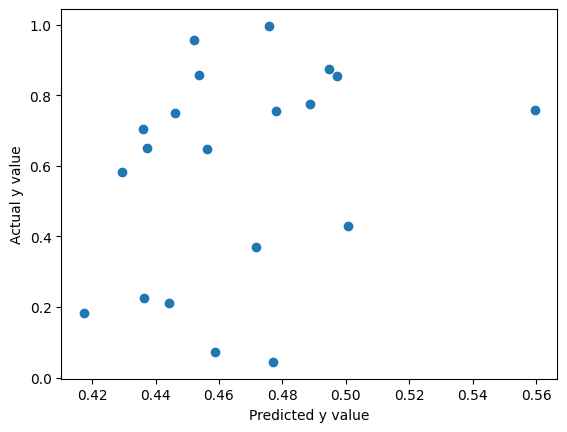

In [142]:
# Plotting the prediction vs actual values of the target value
# Note, there is no relationship since the numbers are randomly generated
# Hence the prediction is poor 
# But this code works! Can be used for real data! 

import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(y_list, y, 'o')
plt.xlabel('Predicted y value')
plt.ylabel('Actual y value')
plt.show()